In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::294138908998:role/service-role/AmazonSageMaker-ExecutionRole-20200831T195894
CPU times: user 933 ms, sys: 146 ms, total: 1.08 s
Wall time: 12 s


In [10]:
import boto3

prefix = 'objectDetetction'
# bucket = s3.Bucket('amtcloud')  # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET

my_region = boto3.session.Session().region_name # set the region of the instance
bucket = 'objectkitcloud' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
prefix = 'objectDetetction'
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket)
    else: 
      s3.create_bucket(Bucket=bucket, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)


S3 bucket created successfully


In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


469771592824.dkr.ecr.ca-central-1.amazonaws.com/object-detection:latest


In [12]:

import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


# MSCOCO validation image files
download('http://images.cocodataset.org/zips/val2017.zip')
download('http://images.cocodataset.org/annotations/annotations_trainval2017.zip')

In [13]:
%%bash
unzip -qo val2017.zip
unzip -qo annotations_trainval2017.zip
rm val2017.zip annotations_trainval2017.zip

In [14]:
%%bash
#Create folders to store the data and annotation files
mkdir generated train train_annotation validation validation_annotation


In [15]:
import json
import logging

def get_coco_mapper():
    original_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
                    21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                    41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
                    61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80,
                    81, 82, 84, 85, 86, 87, 88, 89, 90]
    iter_counter = 0
    COCO = {}
    for orig in original_list:
        COCO[orig] = iter_counter
        iter_counter += 1
    return COCO

In [16]:
def get_mapper_fn(map):  
    def mapper(in_category):
        return map[in_category]
    return mapper

fix_index_mapping = get_mapper_fn(get_coco_mapper())

In [17]:
file_name = './annotations/instances_val2017.json'
with open(file_name) as f:
    js = json.load(f)
    images = js['images']
    categories = js['categories']
    annotations = js['annotations']
    for i in images:
        jsonFile = i['file_name']
        jsonFile = jsonFile.split('.')[0]+'.json'
        
        line = {}
        line['file'] = i['file_name']
        line['image_size'] = [{
            'width':int(i['width']),
            'height':int(i['height']),
            'depth':3
        }]
        line['annotations'] = []
        line['categories'] = []
        for j in annotations:
            if j['image_id'] == i['id'] and len(j['bbox']) > 0:
                line['annotations'].append({
                    'class_id':int(fix_index_mapping(j['category_id'])),
                    'top':int(j['bbox'][1]),
                    'left':int(j['bbox'][0]),
                    'width':int(j['bbox'][2]),
                    'height':int(j['bbox'][3])
                })
                class_name = ''
                for k in categories:
                    if int(j['category_id']) == k['id']:
                        class_name = str(k['name'])
                assert class_name is not ''
                line['categories'].append({
                    'class_id':int(j['category_id']),
                    'name':class_name
                })
        if line['annotations']:
            with open(os.path.join('generated', jsonFile),'w') as p:
                json.dump(line,p)

In [18]:
import os
import json
jsons = os.listdir('generated')

print ('There are {} images have annotation files'.format(len(jsons)))

There are 4952 images have annotation files


In [19]:
import shutil

train_jsons = jsons[:4452]
val_jsons = jsons[4452:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './val2017/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './train/')
    shutil.move('./generated/'+i, './train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './val2017/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './validation/')
    shutil.move('./generated/'+i, './validation_annotation/')

In [20]:

%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 1min 9s, sys: 5.08 s, total: 1min 14s
Wall time: 7min 8s


In [21]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [22]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [23]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=80,
                             mini_batch_size=16,
                             epochs=30,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=600,
                             num_training_samples=4452)

In [24]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [25]:
od_model.fit(inputs=data_channels, logs=True)

2020-09-15 01:59:21 Starting - Starting the training job...
2020-09-15 01:59:29 Starting - Launching requested ML instances......
2020-09-15 02:00:50 Starting - Preparing the instances for training.........
2020-09-15 02:01:59 Downloading - Downloading input data......
2020-09-15 02:03:07 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[09/15/2020 02:03:30 INFO 139960903518016] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_objective_

[09/15/2020 02:06:01 INFO 139960903518016] #quality_metric: host=algo-1, epoch=0, validation mAP <score>=(0.00016328657831144987)
[09/15/2020 02:06:01 INFO 139960903518016] Updating the best model with validation-mAP=0.00016328657831144987
[09/15/2020 02:06:01 INFO 139960903518016] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[09/15/2020 02:06:01 INFO 139960903518016] #progress_metric: host=algo-1, completed 3 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime

[09/15/2020 02:13:53 INFO 139960903518016] Epoch:    5, batches:    100, num_examples:   1600, 45.2 samples/sec, epoch time so far:  0:00:35.362281
[09/15/2020 02:14:28 INFO 139960903518016] Epoch:    5, batches:    200, num_examples:   3200, 45.6 samples/sec, epoch time so far:  0:01:10.219406
[09/15/2020 02:14:54 INFO 139960903518016] #quality_metric: host=algo-1, epoch=5, batch=278 train cross_entropy <loss>=(1.4361035691653004)
[09/15/2020 02:14:54 INFO 139960903518016] #quality_metric: host=algo-1, epoch=5, batch=278 train smooth_l1 <loss>=(0.7338388787753426)
[09/15/2020 02:14:54 INFO 139960903518016] Round of batches complete
[09/15/2020 02:14:54 INFO 139960903518016] Updated the metrics
[09/15/2020 02:15:01 INFO 139960903518016] #quality_metric: host=algo-1, epoch=5, validation mAP <score>=(0.0013657256634761485)
[09/15/2020 02:15:01 INFO 139960903518016] Updating the best model with validation-mAP=0.0013657256634761485
[09/15/2020 02:15:01 INFO 139960903518016] Saved checkpoin

[09/15/2020 02:21:49 INFO 139960903518016] #quality_metric: host=algo-1, epoch=9, batch=278 train cross_entropy <loss>=(1.4006182587311051)
[09/15/2020 02:21:49 INFO 139960903518016] #quality_metric: host=algo-1, epoch=9, batch=278 train smooth_l1 <loss>=(0.6749758588811448)
[09/15/2020 02:21:49 INFO 139960903518016] Round of batches complete
[09/15/2020 02:21:49 INFO 139960903518016] Updated the metrics
[09/15/2020 02:21:55 INFO 139960903518016] #quality_metric: host=algo-1, epoch=9, validation mAP <score>=(0.005569630762732537)
[09/15/2020 02:21:55 INFO 139960903518016] Updating the best model with validation-mAP=0.005569630762732537
[09/15/2020 02:21:56 INFO 139960903518016] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[09/15/2020 02:21:56 INFO 139960903518016] #progress_metric: host=algo-1, completed 33 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1,

[09/15/2020 02:28:53 INFO 139960903518016] #quality_metric: host=algo-1, epoch=13, validation mAP <score>=(0.018455050917429577)
[09/15/2020 02:28:53 INFO 139960903518016] Updating the best model with validation-mAP=0.018455050917429577
[09/15/2020 02:28:53 INFO 139960903518016] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[09/15/2020 02:28:53 INFO 139960903518016] #progress_metric: host=algo-1, completed 46 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 14, "sum": 14.0, "min": 14}}, "EndTim

[09/15/2020 02:36:25 INFO 139960903518016] Epoch:    18, batches:    100, num_examples:   1600, 44.6 samples/sec, epoch time so far:  0:00:35.868601
[09/15/2020 02:37:00 INFO 139960903518016] Epoch:    18, batches:    200, num_examples:   3200, 45.1 samples/sec, epoch time so far:  0:01:10.887993
[09/15/2020 02:37:26 INFO 139960903518016] #quality_metric: host=algo-1, epoch=18, batch=278 train cross_entropy <loss>=(1.3268416701220926)
[09/15/2020 02:37:26 INFO 139960903518016] #quality_metric: host=algo-1, epoch=18, batch=278 train smooth_l1 <loss>=(0.601745223318223)
[09/15/2020 02:37:26 INFO 139960903518016] Round of batches complete
[09/15/2020 02:37:26 INFO 139960903518016] Updated the metrics
[09/15/2020 02:37:32 INFO 139960903518016] #quality_metric: host=algo-1, epoch=18, validation mAP <score>=(0.04838327155382318)
[09/15/2020 02:37:32 INFO 139960903518016] Updating the best model with validation-mAP=0.04838327155382318
[09/15/2020 02:37:32 INFO 139960903518016] Saved checkpoin

[09/15/2020 02:44:21 INFO 139960903518016] #quality_metric: host=algo-1, epoch=22, batch=278 train cross_entropy <loss>=(1.2901230916821946)
[09/15/2020 02:44:21 INFO 139960903518016] #quality_metric: host=algo-1, epoch=22, batch=278 train smooth_l1 <loss>=(0.566928425893833)
[09/15/2020 02:44:21 INFO 139960903518016] Round of batches complete
[09/15/2020 02:44:21 INFO 139960903518016] Updated the metrics
[09/15/2020 02:44:28 INFO 139960903518016] #quality_metric: host=algo-1, epoch=22, validation mAP <score>=(0.0578419454439328)
[09/15/2020 02:44:28 INFO 139960903518016] #progress_metric: host=algo-1, completed 76 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"co

[09/15/2020 02:51:59 INFO 139960903518016] Epoch:    27, batches:    100, num_examples:   1600, 45.2 samples/sec, epoch time so far:  0:00:35.370846
[09/15/2020 02:52:34 INFO 139960903518016] Epoch:    27, batches:    200, num_examples:   3200, 45.6 samples/sec, epoch time so far:  0:01:10.199730
[09/15/2020 02:52:59 INFO 139960903518016] #quality_metric: host=algo-1, epoch=27, batch=278 train cross_entropy <loss>=(1.2592149884747457)
[09/15/2020 02:52:59 INFO 139960903518016] #quality_metric: host=algo-1, epoch=27, batch=278 train smooth_l1 <loss>=(0.5599055015507554)
[09/15/2020 02:52:59 INFO 139960903518016] Round of batches complete
[09/15/2020 02:52:59 INFO 139960903518016] Updated the metrics
[09/15/2020 02:53:05 INFO 139960903518016] #quality_metric: host=algo-1, epoch=27, validation mAP <score>=(0.07229921417809868)
[09/15/2020 02:53:05 INFO 139960903518016] #progress_metric: host=algo-1, completed 93 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count"

In [28]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: object-detection-2020-09-15-01-59-21-467


-----------------!

In [33]:
#!wget -O test.jpg https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
file_name = 'test.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

--2020-09-15 17:31:15--  https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.209.102, 104.17.208.102, 2606:4700::6811:d066, ...
Connecting to images.pexels.com (images.pexels.com)|104.17.209.102|:443... connected.
HTTP request sent, awaiting response... 503 Service Temporarily Unavailable
2020-09-15 17:31:15 ERROR 503: Service Temporarily Unavailable.



In [40]:
file_name = 'test.jpeg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

In [41]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[3.0, 0.48556244373321533, 0.3757118284702301, 0.5867196321487427, 0.6905947923660278, 0.8235950469970703], [3.0, 0.4600829482078552, 0.17569108307361603, 0.5924646854400635, 0.4850132465362549, 0.8622372150421143], [3.0, 0.4020829200744629, 0.45949140191078186, 0.5365787148475647, 0.8059194087982178, 0.8073455691337585], [0.0, 0.30815714597702026, 0.36519619822502136, 0.6344099640846252, 0.43130597472190857, 0.7946056723594666], [0.0, 0.28521719574928284, 0.5173839330673218, 0.4972279965877533, 0.5672135353088379, 0.6337414979934692], [3.0, 0.25906771421432495, 0.6502223014831543, 0.5180425643920898, 0.9049122333526611, 0.7948027849197388], [0.0, 0.24458946287631989, 0.29709652066230774, 0.5210651755332947, 0.3484385907649994, 0.6563950181007385], [3.0, 0.24441754817962646, 0.0, 0.5974932909011841, 0.2418351173400879, 0.8552470207214355], [0.0, 0.2309127151966095, 0.3885977566242218, 0.6358669996261597, 0.43750354647636414, 0.7388849258422852], [0.0, 0.2255570441484451

In [42]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

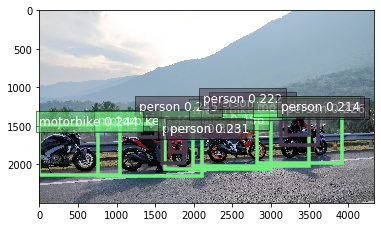

In [43]:
object_categories = ['person', 'bicycle', 'car',  'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 
                     'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                     'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
                     'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                     'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                     'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                     'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable',
                     'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                     'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
                     'toothbrush']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.20

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

In [44]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)